In [1]:
import sys
from pathlib import Path
import os
cwd = os.getcwd()
parent = str(Path(cwd).parents[0])
sys.path.append(parent)

In [2]:
import schemdraw
from schemdraw import flow
import matplotlib.pyplot as plt

Flowchart describing the processs to get from raw data to our sample for analysis. Numbers are from a dictionary called `flowchart_dict` in the `Data Processing and Handling` notebook and the 'Analysis Prep' of the `Analysis` notebook.

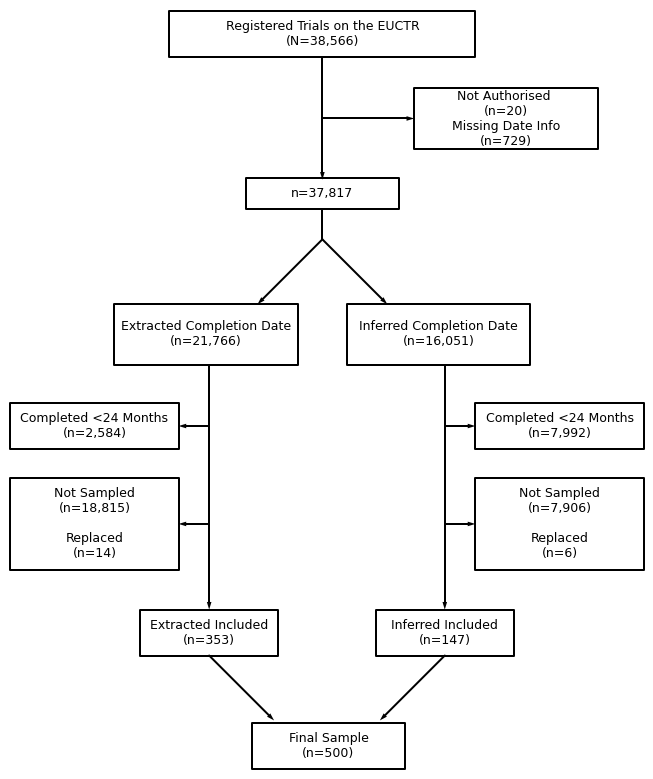

In [42]:
with schemdraw.Drawing() as d:
    d += flow.Box(w=10, h=1.5).label('Registered Trials on the EUCTR\n(N=38,566)')
    d += flow.Arrow('down', l=4).at((5,-.75))
    d += flow.Arrow('right').at((5,-2.75))
    d += flow.Box(w=6, h=2).label('Not Authorised \n(n=20)\nMissing Date Info\n(n=729)')
    d += flow.Box(w=5, h=1).label('n=37,817').at((2.5,-5.2))
    d += flow.Line('down', l=1).at((5, -5.7))
    d += flow.Arrow(l=3).theta(-45).at((5,-6.7))
    d += flow.Box(w=6, h=2).label('Inferred Completion Date\n(n=16,051)').at((5.8,-8.8))
    d += flow.Arrow(l=3).theta(225).at((5,-6.7))
    d += flow.Box(w=6, h=2).label('Extracted Completion Date\n(n=21,766)').at((4.2,-8.8))
    d += flow.Line('down', l=2).at((1.3, -10.8))
    d += flow.Arrow('left', l=1)
    d += flow.Box(w=5.5, h=1.5).label('Completed <24 Months\n(n=2,584)')
    d += flow.Line('down', l=2).at((9, -10.8))
    d += flow.Arrow('right', l=1)
    d += flow.Box(w=5.5, h=1.5).label('Completed <24 Months\n(n=7,992)')
    
    d += flow.Arrow('left', l=1).at((1.3, -16))
    d += flow.Box(w=5.5, h=3).label('Not Sampled\n(n=18,815)\n\nReplaced\n(n=14)')
    
    d += flow.Arrow('right', l=1).at((9, -16))
    d += flow.Box(w=5.5, h=3).label('Not Sampled\n(n=7,906)\n\nReplaced\n(n=6)')
    
    d += flow.Arrow('down', l=6).at((9, -12.8))
    d += flow.Box(w=4.5, h=1.5).label('Inferred Included\n(n=147)')
    d += flow.Arrow('down', l=6).at((1.3, -12.8))
    d += flow.Box(w=4.5, h=1.5).label('Extracted Included\n(n=353)')
    
    #Final
    d += flow.Arrow(l=3).theta(-45).at((1.3,-20.3))
    d += flow.Arrow(l=3).theta(225).at((9,-20.3))
    d += flow.Box(w=5, h=1.5).label('Final Sample\n(n=500)').at((7.7,-22.5))

#d.save(parent + '/data/Figures/flowchart.jpg')

# Upset Plot

In [12]:
from upsetplot import from_indicators, plot
import pandas as pd

In [29]:
upset_df = pd.read_csv(parent + '/data/graphing_data/upset_data.csv').drop('Unnamed: 0', axis=1)
upset_df.columns = ['EUCTR', 'ClinicalTrials.gov', 'ISRCTN', 'Journal Publication']

upset_df = upset_df.replace(1,True)
upset_df = upset_df.replace(0,False)

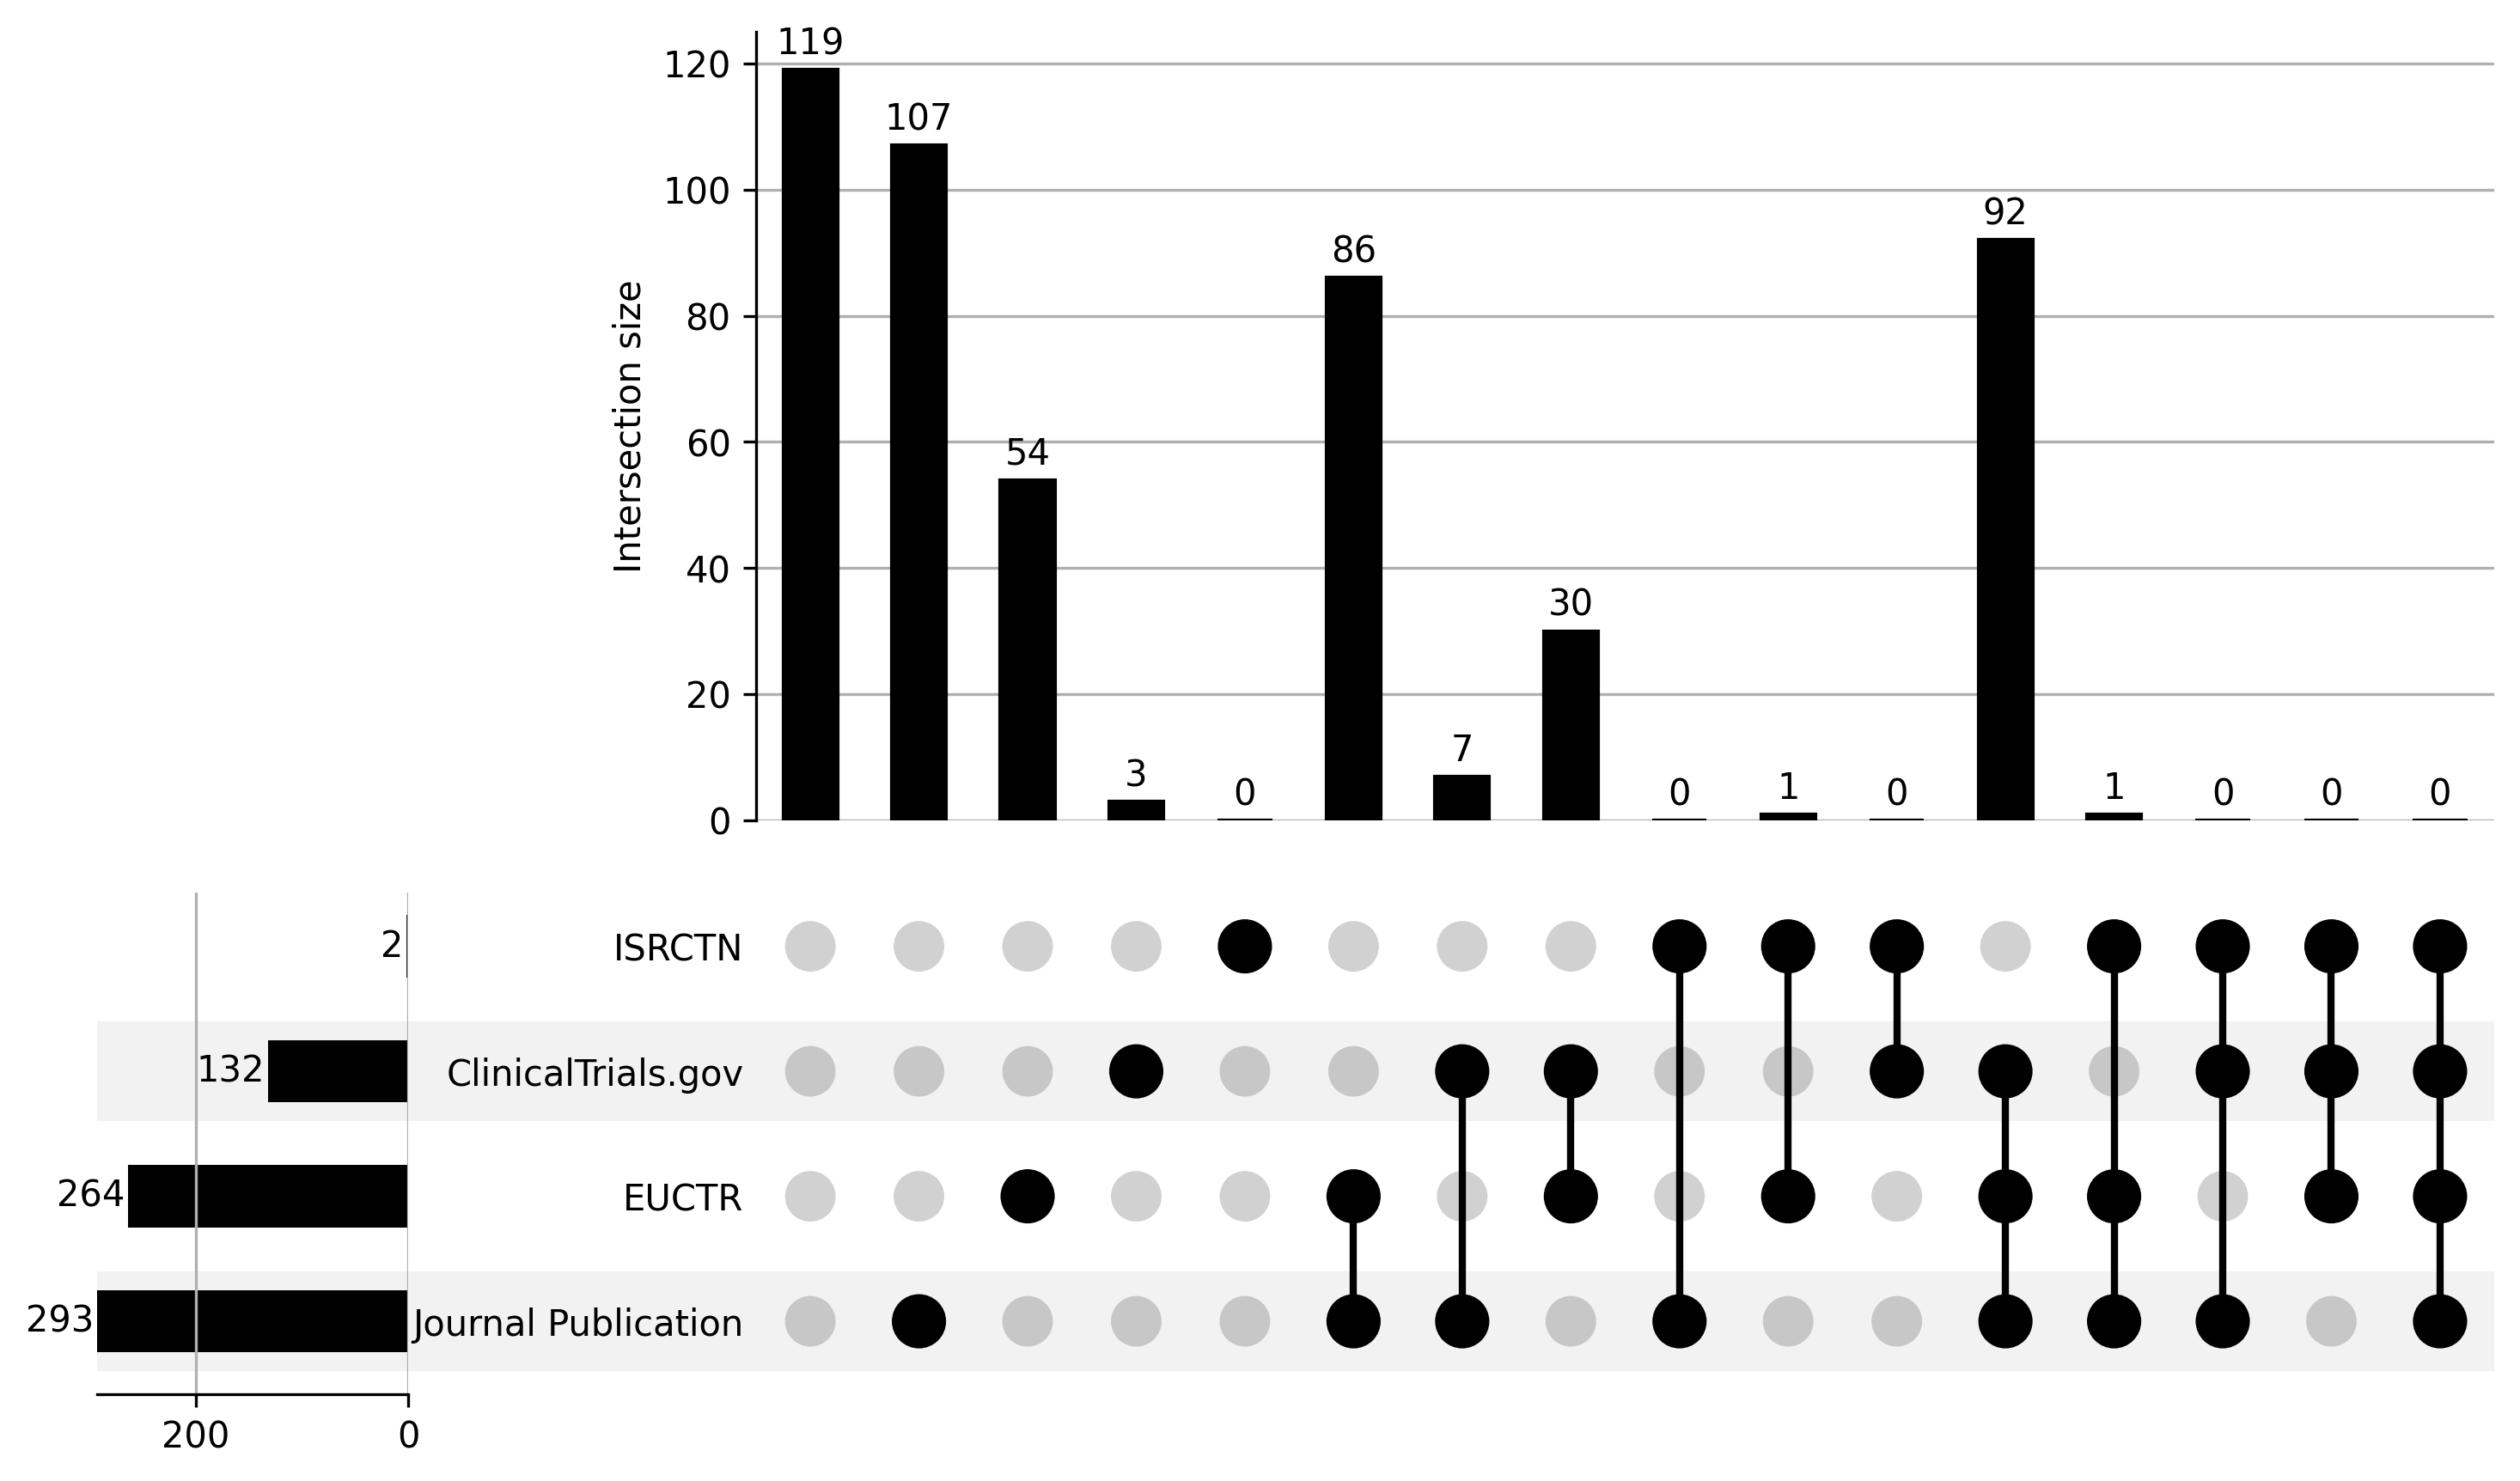

In [33]:
fig = plt.figure(figsize=(12, 7), dpi=300)
plot(from_indicators(["EUCTR", "ClinicalTrials.gov", "ISRCTN", "Journal Publication"],
                      data=upset_df), 
     sort_by='degree', 
     show_counts=True, 
     fig=fig, 
     element_size=None, 
     totals_plot_elements=3,
     include_empty_subsets=True
    )

plt.show()

# Start Year Graphs

In [34]:
from matplotlib.patches import Patch

In [38]:
graphing_df = pd.read_csv(parent + '/data/graphing_data/start_year_data.csv')

data = graphing_df[graphing_df.any_results_inc == 0][['Trial Start Year']]

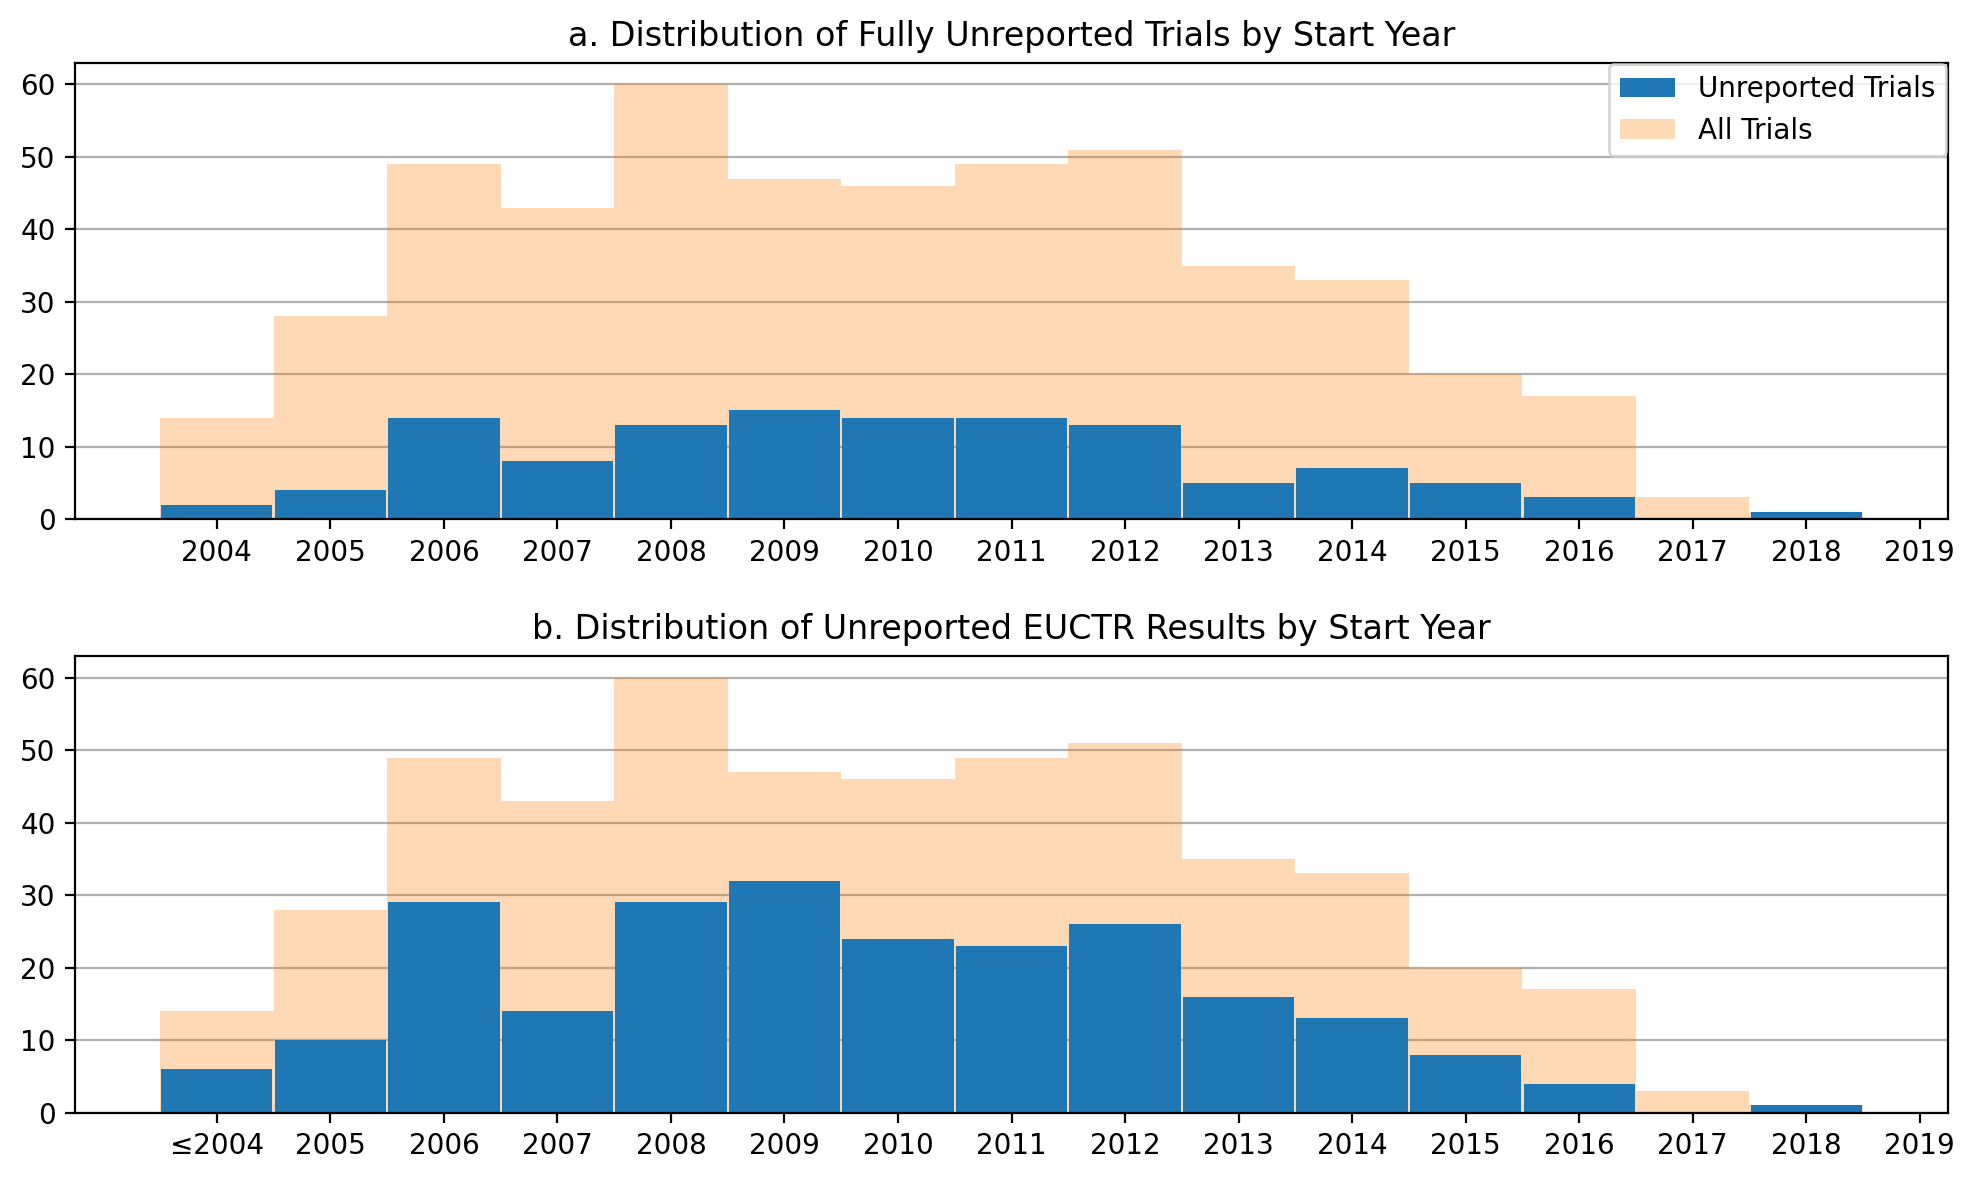

In [40]:
fig = plt.figure(figsize=(10, 6), dpi=200)

bins = list(range(int(data.min()[0]),int(data.max()[0]+2)))

#Graph 1
ax1 = plt.subplot(211)

data1 = graphing_df[graphing_df.any_results_inc == 0][['Trial Start Year']]
bins1 = list(range(int(data.min()[0]),int(data.max()[0]+2)))

ax1.hist(graphing_df['Trial Start Year'], bins1, align='left', histtype='stepfilled', color='#ff7f0e', alpha=.3)

ax1.hist(data1, bins1, align='left', color='#1f77b4', rwidth=.98)

ax1.set_axisbelow(True)
ax1.grid(axis='y')
ax1.set_xticks(bins)
ax1.set_yticks(range(0,61,10))
plt.title('a. Distribution of Fully Unreported Trials by Start Year')

#Graph 2
ax2 = plt.subplot(212)

#Making first bin anything from 2004 or earlier because 1 trial is from 1999
data2 = np.clip(graphing_df[graphing_df.euctr_results_inc == 0][['Trial Start Year']], 2004, 2020)
bins2 = list(range(2004,2020))

names = []
for b in bins:
    if b == 2004:
        names.append('≤2004')
    else:
        names.append(str(b))

ax2.hist(graphing_df['Trial Start Year'], bins1, align='left', histtype='stepfilled', color='#ff7f0e', alpha=.3)
        
ax2.hist(data2, bins2, align='left', color='#1f77b4', rwidth=.98)

ax2.set_axisbelow(True)
ax2.grid(axis='y')
ax2.set_xticks(bins)
ax2.set_xticklabels(names)
ax2.set_yticks(range(0,61,10))
plt.title('b. Distribution of Unreported EUCTR Results by Start Year')

legend_elements = [Patch(facecolor='#1f77b4',label='Unreported Trials'), 
                   Patch(facecolor='#ff7f0e',label='All Trials', alpha=.3)]

fig.legend(handles=legend_elements, loc=1, bbox_to_anchor=(.985,.95))

plt.tight_layout()
plt.subplots_adjust(hspace=.3)
plt.show()

#fig.savefig('unreported_trials.png')